# Zadanie 02 - Wyciskanie soku

### Zmienne

In [1]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.9 MB/s eta 0:00:00


In [2]:
BATCH_SIZE = 128
LIMIT_PICS = 8
EPOCH_NUM = 3
LEARNING_RATE = 0.0001
LOGGING_INTERVAL = 10
OPTUNA_RUNS = 6

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import optuna
import torch.optim as optim
from tqdm import tqdm
from prettytable import PrettyTable

torch.manual_seed(69)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


## Wszytko się zaczyna i kończy na danych

1. Sprawdź w jaki sposób w Twoim frameworku można załadowac zbiór CIFAR-10. Pamiętaj o podziale na zbiór treningowy i testowy. Zwykle CIFAR-10 jest już podzielony na 50 000 przykładów treningowych i 10 000 testowych.

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5)
        )
    ]
)

trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


2. Wyświetl kilka obrazów z zestawu wraz z tekstową etykietą.

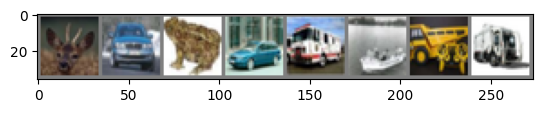

deer  car   frog  car   truck ship  truck truck



In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:LIMIT_PICS]))
print(' '.join(f'{classes[labels[j]]:5s}' + ('\n' if j % 8 == 7 else '') for j in range(LIMIT_PICS)))

## Projektujemy architekturę sieci neuronowej

3. Zbuduj swoją sieć korzystając z "bloczków" dostępnych w twoim frameworku. Rozwiązujemy problem klasyfikacji, a więc na wyjściu sieci chcemy mieć znormalizowane wartości pewności (ala prawdopodobieństwa.) z przedziału 0 - 1, sumujące się do 1. Zatem, na wyjściu z sieci powinno być 10 neuronów, których odpowiedź przepuszczamy przez funkcję softmax.


In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

net = Net()

4. Większość framework-ów udostępnia funkcje do narysowania grafu obliczeniowego modelu. Wyślwietl teraz ten graf. Czasem jest to tak proste jak print(model) . Wypisz także ilość jego parametrów.

In [7]:
print(net, '\n')

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
) 

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| conv1.weight |    450     |
|  conv1.bias  |     6      |
| conv2.weight |    2400    |
|  conv2.bias  |     16     |
|  fc1.weight  |   48000    |
|   fc1.bias   |    120     |
|  fc2.weight  |   10080    |
|   fc2.bias   |     84     |
|  fc3.weight  |    840     |
|   fc3.bias   |     10     |
+--------------+------------+
Total Trainable Params: 62006


62006

5. Zainicjalizuj sieć wartościami losowymi właściwymi dla użytych funkcji aktywacji. W przypadku ReLU będzie to He initialization. Niektóre frameworki domyślnie inicjalizują wagi sieci właściwą metodą. Sprawdź to i napisz jak jest w Twoim framework-u.

In [8]:
class HeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')

        self.fc2 = nn.Linear(120, 84)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')

        self.fc3 = nn.Linear(84, 10)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

he_net = HeNet()

## Zapętlamy się w treningu

6. Trenujemy sieć za pomocą spadku po gradiencie (w pewnym ulepszonym wariancie). Kluczowe będzie określenie funkcji kosztu, z której ten gradient będziemy otrzymywać. Dla problemu klasyfikacji właściwą funkcją będzie entropia krzyżowa (Categorical Cross-Entropy Loss). Skonfiguruj taką funkcję.

In [9]:
criterion = nn.CrossEntropyLoss()

7. Będziemy monitorować proces treningu na podstawie training loss oraz validation loss. A dopiero po całym treningu raportujemy test loss. Zatem zadbaj teraz o wydzielenie ze zbioru treningowego kawałka (10%) na potrzeby walidacji. Dane walidacyjne powinny zostać wylosowane z całej puli danych treningowych.

In [10]:
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

valloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

8. Trening przeprowadzamy w pętli, małymi krokami iterując po zbiorze danych w mini-batch-ach. Pamiętaj o wymieszaniu danych na samym początku. Do wykonywania kroków uczenia wykorzystaj optymalizator Adam (lub jego wariant). Zaimplementuj taką pętlę, opisz jak działa.

> Pętla działa stosunkowo prosto, przez wyznaczoną liczbę epok uczymy nasz model na zbiorze treningowym, a następnie walidujemy go na zbiorze walidacyjnym.

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)

def train(trainloader, valloader, model, criterion, optimizer):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    print(f'\nStart {type(model)} Training')
    last_acc = 0
    for epoch in range(EPOCH_NUM):
        model.train()
        running_loss = 0.0
        pbar = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc=f'Epoch {epoch+1}/{EPOCH_NUM} [Training]')

        for i, data in pbar:
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % LOGGING_INTERVAL == 0:
                avg_loss = running_loss / LOGGING_INTERVAL
                pbar.set_postfix({'loss': f'{avg_loss:.3f}'})
                running_loss = 0.0

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            pbar_val = tqdm(enumerate(valloader, 0), total=len(valloader), desc=f'Epoch {epoch+1}/{EPOCH_NUM} [Validation]')

            for i, data in pbar_val:
                inputs, labels = data[0].to(device), data[1].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                if i % LOGGING_INTERVAL == 0:
                    avg_val_loss = val_loss / (i + 1)
                    pbar_val.set_postfix({
                        'val_loss': f'{avg_val_loss:.3f}',
                        'accuracy': f'{100 * correct / total:.2f}%'
                    })

            last_acc = 100 * correct / total
            print(f'Accuracy: {last_acc:.2f}%')

    print('Finished Training')
    return last_acc

9. Sprawdź czy wszystko działa (uruchom trening). Twoja pętla ucząca powinna raportować co pewien interwał aktualny loss dla danych treningowych oraz loss dla danych validacyjnych.

In [12]:
train(trainloader, valloader, net, criterion, optimizer)
train(trainloader, valloader, he_net, criterion, optimizer)

cuda:0

Start <class '__main__.Net'> Training


Epoch 1/3 [Validation]: 100%|██████████| 40/40 [00:01<00:00, 30.91it/s, val_loss=2.176, accuracy=28.12%]

Accuracy: 28.22%



Epoch 2/3 [Validation]: 100%|██████████| 40/40 [00:01<00:00, 32.28it/s, val_loss=2.145, accuracy=31.28%]

Accuracy: 31.20%



Epoch 3/3 [Validation]: 100%|██████████| 40/40 [00:01<00:00, 32.34it/s, val_loss=2.129, accuracy=32.54%]

Accuracy: 32.46%
Finished Training
cuda:0

Start <class '__main__.HeNet'> Training



Epoch 1/3 [Validation]: 100%|██████████| 40/40 [00:01<00:00, 33.03it/s, val_loss=2.302, accuracy=11.34%]

Accuracy: 10.86%



Epoch 2/3 [Validation]: 100%|██████████| 40/40 [00:01<00:00, 32.33it/s, val_loss=2.302, accuracy=11.34%]

Accuracy: 10.86%



Epoch 3/3 [Validation]: 100%|██████████| 40/40 [00:01<00:00, 32.86it/s, val_loss=2.302, accuracy=11.34%]

Accuracy: 10.86%
Finished Training


10.86

## Hiperparametryzujemy sieć i jej trening

10. Na koniec treningu zaraportuj wynik dokładności klasyfikacji dla wytrenowanej sieci na całym testowym datasecie (10 000). accuracy = (number of correct predictions) / (number of all predictions) . W tym momencie model powinno się przełączyć w tryb inferencji (niezbędne gdy używamy np. Dropout). Podsumuj działanie całej pętli i podaj wynik bazowy accuracy.

> Robimy to samo co wcześniej, tylko nie poprawiamy wag na podstawie gradientu (nie liczymy go w ogóle).

In [13]:
def evaluate(model):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    correct = 0
    total = 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the {type(model)} on the {len(testset)} test images: {100 * correct / total:.2f} %')

evaluate(net)
evaluate(he_net)

cuda:0
Accuracy of the <class '__main__.Net'> on the 10000 test images: 33.53 %
cuda:0
Accuracy of the <class '__main__.HeNet'> on the 10000 test images: 10.00 %


11. Wyodrębnij swój dotyczasowy kod jako funkcję, która na wejściu przyjmuje wartości hiperparametrów (wszystkich, które znajdziesz, ale koniecznie learning rate i rozmiar sieci definiowany np. jako ilość warstw i ich rozmiar), a zwracać będzie wynik accuracy dla zbioru testowego.

In [14]:
def objective(trial):
    model = Net()

    batch_size = trial.suggest_int('batch_size', 64, 256)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    accuracy = train(train_loader, val_loader, model, criterion, optimizer)
    return accuracy

12. Korzystając z biblioteki do poszukiwania hiperparametrów, np. Optuna, skonfiguruj przeszukiwanie przestrzeni hiperparametrów. Opisz jak to działa.

> Ogólnie przeszukiwanie hiperparametrów definiujemy w dużym skrócie tak, że na początku wyznaczamy przestrzeń możliwych hiperparametrów (dyskretna lub nie, na potrzeby tego labu powiedzmy że nie ma to znaczenia), a następnie definiujemy jakąś logikę, która pozwoli nam znaleźć takie, które dają możliwie najlepsze rezultaty (w naszym przypadku użyjemy czegoś mądrego, i będziemy szukać maksymalnego accuracy).

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=OPTUNA_RUNS)

print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

[I 2024-10-24 11:45:06,128] A new study created in memory with name: no-name-60ee3c8c-afae-4552-82f8-80df58bcdbe6
<ipython-input-14-aec15c74f814>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-14-aec15c74f814>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)


cuda:0

Start <class '__main__.Net'> Training


Epoch 1/3 [Validation]: 100%|██████████| 62/62 [00:01<00:00, 44.59it/s, val_loss=2.352, accuracy=10.89%]


Accuracy: 10.88%


Epoch 2/3 [Validation]: 100%|██████████| 62/62 [00:01<00:00, 47.42it/s, val_loss=2.352, accuracy=10.89%]


Accuracy: 10.88%


Epoch 3/3 [Validation]: 100%|██████████| 62/62 [00:01<00:00, 45.85it/s, val_loss=2.352, accuracy=10.89%]
[I 2024-10-24 11:45:54,795] Trial 0 finished with value: 10.88 and parameters: {'batch_size': 81, 'lr': 0.09943738419570552, 'weight_decay': 9.032163669645892e-05}. Best is trial 0 with value: 10.88.


Accuracy: 10.88%
Finished Training
cuda:0

Start <class '__main__.Net'> Training


Epoch 1/3 [Validation]: 100%|██████████| 37/37 [00:01<00:00, 28.48it/s, val_loss=2.077, accuracy=37.94%]


Accuracy: 37.92%


Epoch 2/3 [Validation]: 100%|██████████| 37/37 [00:01<00:00, 18.96it/s, val_loss=2.040, accuracy=41.54%]


Accuracy: 41.48%


Epoch 3/3 [Validation]: 100%|██████████| 37/37 [00:01<00:00, 28.80it/s, val_loss=2.014, accuracy=44.09%]
[I 2024-10-24 11:46:39,101] Trial 1 finished with value: 44.18 and parameters: {'batch_size': 138, 'lr': 0.0011676855335702831, 'weight_decay': 0.002283001058636978}. Best is trial 1 with value: 44.18.


Accuracy: 44.18%
Finished Training
cuda:0

Start <class '__main__.Net'> Training


Epoch 1/3 [Validation]: 100%|██████████| 58/58 [00:01<00:00, 41.78it/s, val_loss=2.192, accuracy=27.38%]


Accuracy: 27.34%


Epoch 2/3 [Validation]: 100%|██████████| 58/58 [00:01<00:00, 29.32it/s, val_loss=2.145, accuracy=31.58%]


Accuracy: 31.30%


Epoch 3/3 [Validation]: 100%|██████████| 58/58 [00:01<00:00, 35.94it/s, val_loss=2.125, accuracy=33.33%]
[I 2024-10-24 11:47:26,261] Trial 2 finished with value: 33.02 and parameters: {'batch_size': 87, 'lr': 6.858888245731995e-05, 'weight_decay': 0.006993569127053266}. Best is trial 1 with value: 44.18.


Accuracy: 33.02%
Finished Training
cuda:0

Start <class '__main__.Net'> Training


Epoch 1/3 [Validation]: 100%|██████████| 27/27 [00:01<00:00, 16.17it/s, val_loss=2.303, accuracy=9.96%]


Accuracy: 9.94%


Epoch 2/3 [Validation]: 100%|██████████| 27/27 [00:01<00:00, 20.46it/s, val_loss=2.303, accuracy=9.14%]


Accuracy: 9.30%


Epoch 3/3 [Validation]: 100%|██████████| 27/27 [00:01<00:00, 20.67it/s, val_loss=2.303, accuracy=9.83%]
[I 2024-10-24 11:48:10,411] Trial 3 finished with value: 9.64 and parameters: {'batch_size': 187, 'lr': 0.04489096992966536, 'weight_decay': 0.0009064269870579382}. Best is trial 1 with value: 44.18.


Accuracy: 9.64%
Finished Training
cuda:0

Start <class '__main__.Net'> Training


Epoch 1/3 [Validation]: 100%|██████████| 74/74 [00:01<00:00, 53.06it/s, val_loss=2.221, accuracy=22.97%]


Accuracy: 22.98%


Epoch 2/3 [Validation]: 100%|██████████| 74/74 [00:01<00:00, 39.55it/s, val_loss=2.193, accuracy=25.75%]


Accuracy: 25.72%


Epoch 3/3 [Validation]: 100%|██████████| 74/74 [00:01<00:00, 55.26it/s, val_loss=2.179, accuracy=26.70%]
[I 2024-10-24 11:48:58,634] Trial 4 finished with value: 26.62 and parameters: {'batch_size': 68, 'lr': 3.4414062737659075e-05, 'weight_decay': 1.3537997524048139e-05}. Best is trial 1 with value: 44.18.


Accuracy: 26.62%
Finished Training
cuda:0

Start <class '__main__.Net'> Training


Epoch 1/3 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 15.71it/s, val_loss=2.368, accuracy=9.34%]


Accuracy: 9.56%


Epoch 2/3 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 15.66it/s, val_loss=2.368, accuracy=9.34%]


Accuracy: 9.56%


Epoch 3/3 [Validation]: 100%|██████████| 20/20 [00:01<00:00, 15.45it/s, val_loss=2.368, accuracy=9.34%]
[I 2024-10-24 11:49:41,408] Trial 5 finished with value: 9.56 and parameters: {'batch_size': 252, 'lr': 0.07965876632990339, 'weight_decay': 0.00828652394112367}. Best is trial 1 with value: 44.18.


Accuracy: 9.56%
Finished Training
Best hyperparameters: {'batch_size': 138, 'lr': 0.0011676855335702831, 'weight_decay': 0.002283001058636978}
Best accuracy: 44.18


13. Teraz możesz dołożyć do swojego kodu wszlekie znane ci triki i ulepszenia, które mogą pozwolić uzyskać możliwie dobre wyniki. Jeżeli techniki, którymi się posługujesz (np. Dropout) mają jakieś hiperparametry to wyciągnij je do interfejsu funkcji trenującej. Opisz jakie ulepszenia stosujesz, jeżeli nie znasz żadnych to spróbuj skonfigurować klasyczną regularyzację L2.

> Wybieram lepszy model :)

In [16]:
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 49 (delta 6), reused 30 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 2.02 MiB | 4.40 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Already up to date.


In [17]:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-2_8s84p8


In [18]:
model_name = 'ViT-B_32'
![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][400.0 MiB/400.0 MiB]   25.0 MiB/s                                   
Operation completed over 1 objects/400.0 MiB.                                    


In [19]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)
jax.local_devices()

[CudaDevice(id=0)]

In [20]:
import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

INFO:absl:Created `ArrayHandler` with primary_host=0, replica_id=0


In [21]:
labelnames = dict(
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2
    show_img(img, axs[i // n][i % n], title)

In [22]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
del config


INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmpsj8f6gqitfds
INFO:absl:For 'cifar10/3.0.2': fields info.[citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.12bef995f3fe4db3b70020848014972b...


Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.E1NXWP_3.0.2/cifar10-train.tfrecord*...:   0%|         …

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/incomplete.E1NXWP_3.0.2/cifar10-train.tfrecord*. Number of examples: 50000 (shards: [50000])


Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.E1NXWP_3.0.2/cifar10-test.tfrecord*...:   0%|          …

INFO:absl:Done writing /root/tensorflow_datasets/cifar10/incomplete.E1NXWP_3.0.2/cifar10-test.tfrecord*. Number of examples: 10000 (shards: [10000])
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


In [23]:
batch = next(iter(ds_train.as_numpy_iterator()))
model_config = models_config.MODEL_CONFIGS[model_name]
model_config
model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [24]:
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


In [25]:
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__, params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__, params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (1, 10)


In [26]:
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(dict(params=params), inputs, train=False))

In [27]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total


14. Puść tyle iteracji poszukiwania hiperparametrów na ile pozwala ci czas i dostępne zasoby obliczeniowe. Pamiętaj, aby zapisywać najlepsze konfiguracje hiperparametrów i wyniki dla nich. Podaj najlepszą konfigurację i jej wynik. Opisz swoje wnioski z tego doświadczenia.

In [28]:
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
accum_steps = 8
base_lr = 0.03

In [29]:
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)

tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [30]:
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [07:57<00:00,  4.77s/it]


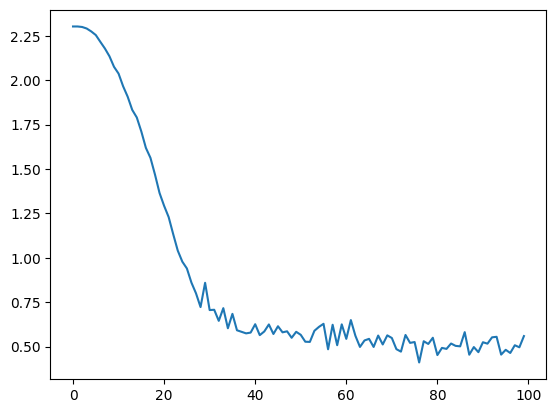

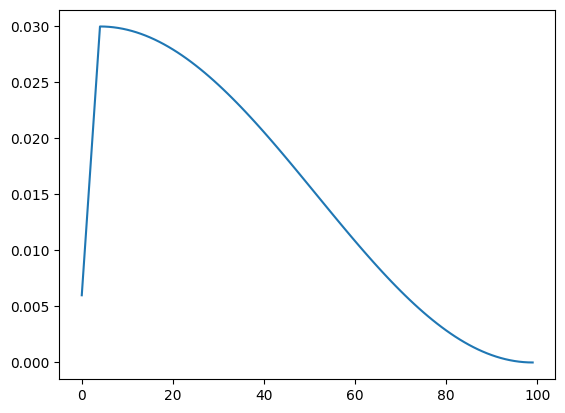

In [31]:
losses = []
lrs = []

for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [32]:
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:38<00:00,  2.05s/it]


Array(0.9769737, dtype=float32)

> Wniosek jest prosty. Lepszy model daje lepsze wyniki. W naszym przypadku mamy skok z 44.18% na 97.7%, czyli o ponad 50 punktów procentowych.

15. Na zakończenie użyj swojej najlepszej sieci do klasyfikacji kilku ręcznie wybranych obrazków ze zbioru testowego. Wyświetl obrazy, ich prawdziwą etykietę oraz etykietę przewidzianą przez sieć. Wyświetl kategorie tekstowo, nie jako liczby.

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
  0%|          | 0/19 [00:00<?, ?it/s]


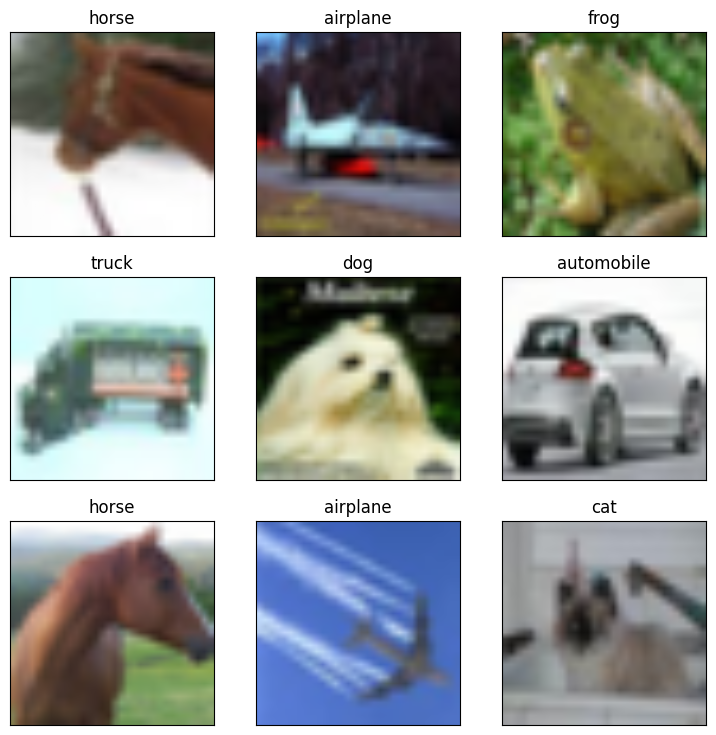

In [45]:
images = None
predicted = None

steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    images = torch.from_numpy(batch['image'][:LIMIT_PICS])
    predicted = vit_apply_repl(params_repl, batch['image'])[:LIMIT_PICS]
    break

images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)